# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

In [16]:
# GROUP MEMBER : 
# GALLAIS SIMON, SCHWARTZ OSCAR, LEITAO MATHIS, BASSAGET HUGO, DE BLAUWE CHARLES,  DEPLANQUE GAUTIER, QUARANTA BENOIT

import numpy as np, pandas as pd, re, warnings
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, os, sys, textwrap
from typing import List
from pathlib import Path
pd.set_option("display.max_columns", 200)

# libs ML

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import clone

HAS_XGB = HAS_LGBM = HAS_CAT = False
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    pass
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    pass
try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    pass

# Load
train_raw = pd.read_csv("data/train.csv")
test_raw  = pd.read_csv("data/test.csv")
print(train_raw.shape, test_raw.shape)
 




(891, 12) (418, 11)


## 2. Exploratory Data Analysis (EDA)

Now, let's explore the data to understand its structure, find patterns, and identify missing values.

== Shapes ==
train: (891, 13) test: (418, 12)

== Colonnes ==
train: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize']
test : ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize']

== Résumé colonnes (train) – tri par % manquants ==
   dataset       column    dtype  n_non_null  missing  missing_%  n_unique  \
10   train        Cabin   object         204      687      77.10       147   
5    train          Age  float64         714      177      19.87        88   
11   train     Embarked   object         889        2       0.22         3   
12   train   FamilySize    int64         891        0       0.00         9   
9    train         Fare  float64         891        0       0.00       248   
3    train         Name   object         891        0       0.00       891   
7    train        Parch    int64         891        0       0.00         7 

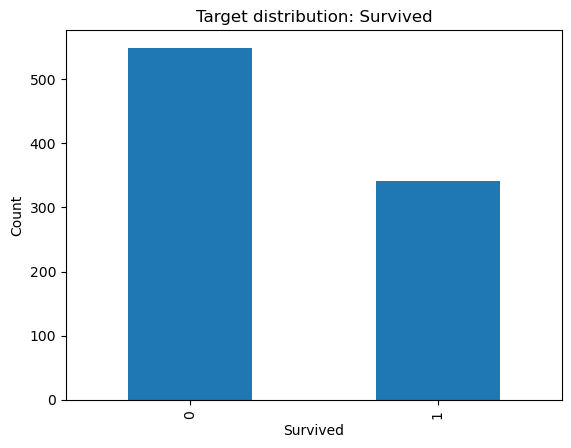


== Colonnes communes train/test = 12
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilySize']

== Train vs Test: types, cardinalités, manquants ==
         column dtype_train dtype_test  n_unique_train  n_unique_test  \
4           Age     float64    float64              88             79   
9         Cabin      object     object             147             76   
10     Embarked      object     object               3              3   
11   FamilySize       int64      int64               9              9   
8          Fare     float64    float64             248            169   
2          Name      object     object             891            418   
6         Parch       int64      int64               7              8   
0   PassengerId       int64      int64             891            418   
1        Pclass       int64      int64               3              3   
3           Sex      object     object               2      

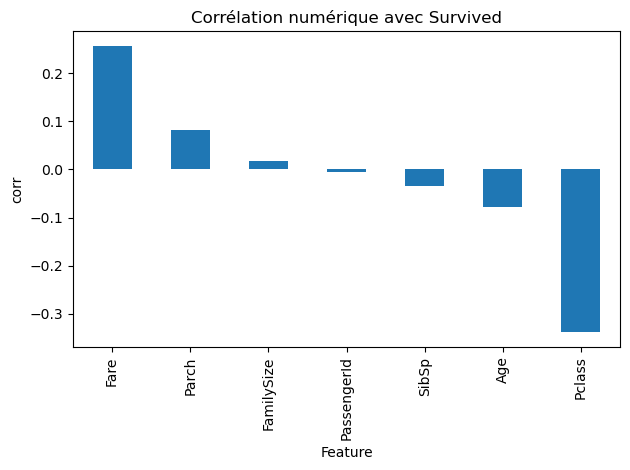


== Paires numériques fortement corrélées (|corr| >= 0.3) ==
   level_0     level_1      corr
17   SibSp  FamilySize  0.890712
19   Parch  FamilySize  0.783111
15   SibSp       Parch  0.414838
14     Age  FamilySize -0.301914
11     Age       SibSp -0.308247
6   Pclass         Age -0.369226
9   Pclass        Fare -0.549500

== Taux de survie par Sex ==
        count  survival_rate
Sex                         
female    314       0.742038
male      577       0.188908

== Taux de survie par Pclass ==
        count  survival_rate
Pclass                      
1         216       0.629630
2         184       0.472826
3         491       0.242363

== Taux de survie par Embarked ==
          count  survival_rate
Embarked                      
C           168       0.553571
Q            77       0.389610
S           644       0.336957

== Taux de survie par SibSp ==
       count  survival_rate
SibSp                      
0        608       0.345395
1        209       0.535885
2         28     

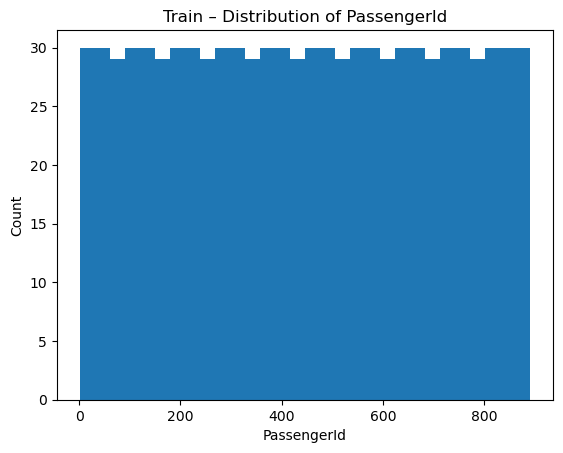

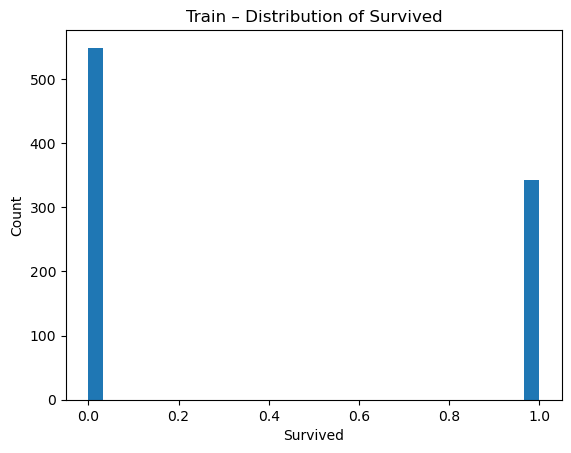

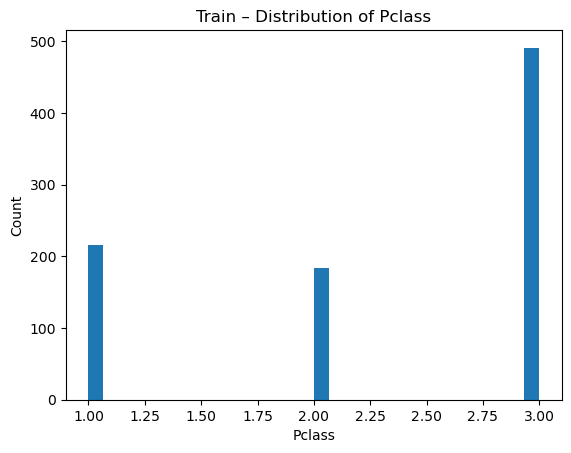

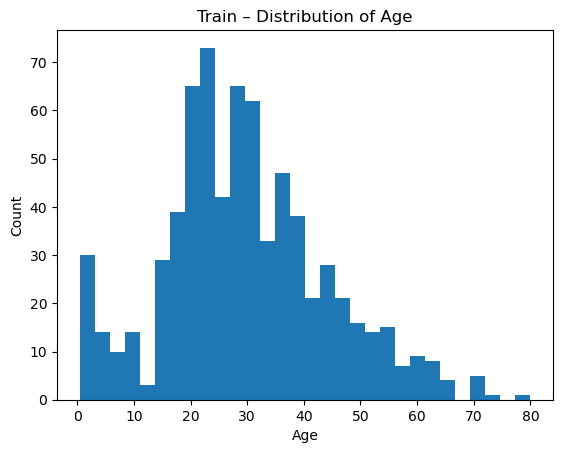

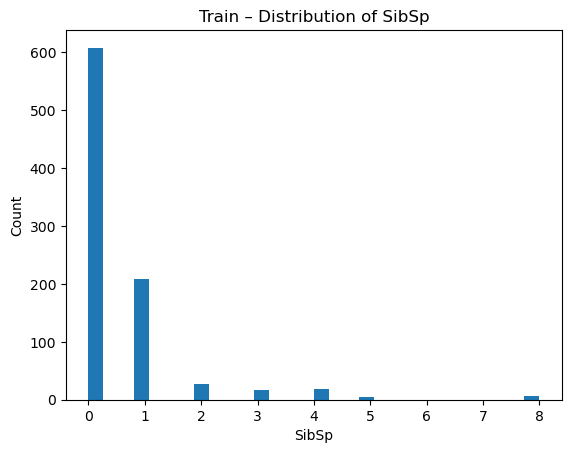

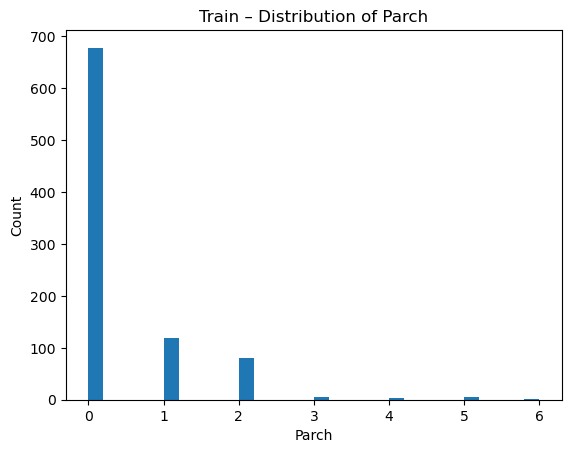

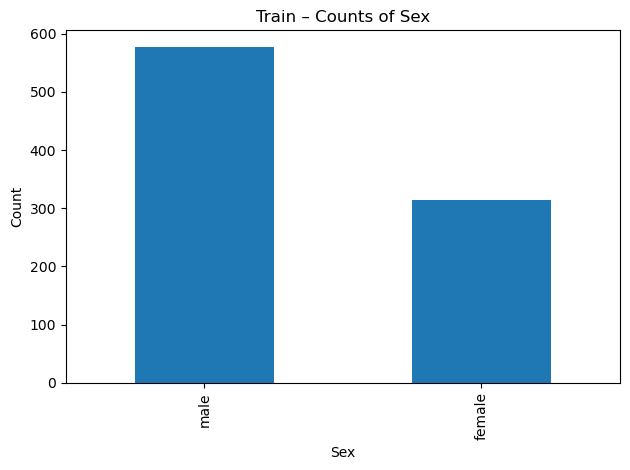

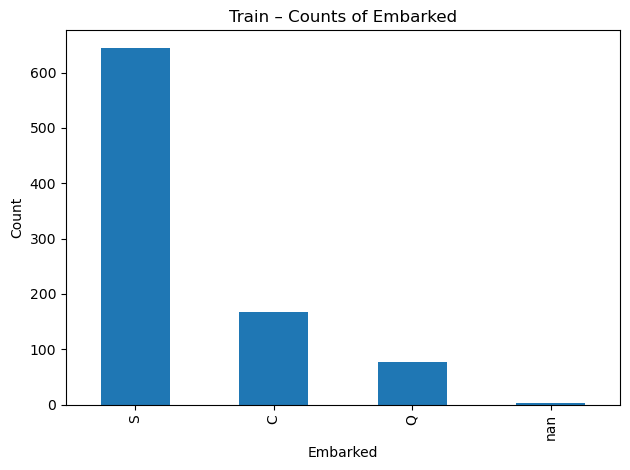


== Survie par FamilySize (si dispo) ==
            count  survival_rate
FamilySize                      
1             537       0.303538
2             161       0.552795
3             102       0.578431
4              29       0.724138
5              15       0.200000
6              22       0.136364
7              12       0.333333
8               6       0.000000
11              7       0.000000


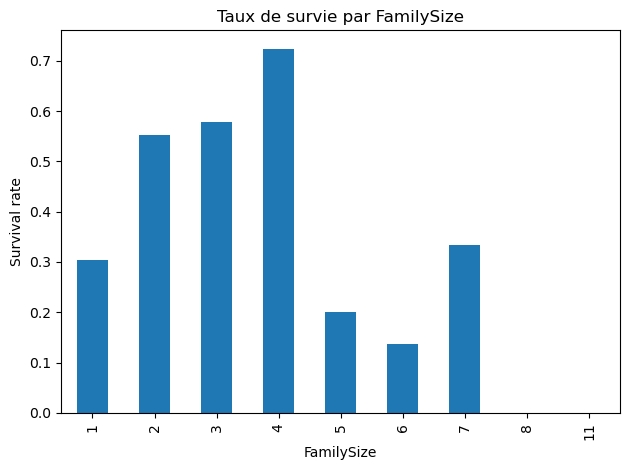

In [10]:
def summarize_dataframe(df: pd.DataFrame, name: str) -> pd.DataFrame:
    info = []
    for col in df.columns:
        s = df[col]
        info.append({
            "dataset": name,
            "column": col,
            "dtype": str(s.dtype),
            "n_non_null": s.notna().sum(),
            "missing": s.isna().sum(),
            "missing_%": round(100 * s.isna().mean(), 2),
            "n_unique": s.nunique(dropna=True),
            "sample_values": ", ".join(map(str, s.dropna().unique()[:5]))
        })
    return pd.DataFrame(info).sort_values(["missing_%", "column"], ascending=[False, True])

def describe_numeric(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return pd.DataFrame()
    desc = df[num_cols].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).T
    desc["missing_%"] = df[num_cols].isna().mean().round(4)*100
    return desc

def describe_categorical(df: pd.DataFrame, top_n: int = 10) -> dict:
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    out = {}
    for c in cat_cols:
        vc = df[c].value_counts(dropna=False).head(top_n)
        out[c] = vc
    return out

def plot_histograms(df: pd.DataFrame, cols: List[str], title_prefix: str=""):
    for c in cols:
        fig = plt.figure()
        df[c].dropna().plot(kind="hist", bins=30)
        plt.title(f"{title_prefix}Distribution of {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.show()

def plot_bar_counts(df: pd.DataFrame, cols: List[str], title_prefix: str=""):
    for c in cols:
        fig = plt.figure()
        df[c].value_counts(dropna=False).plot(kind="bar")
        plt.title(f"{title_prefix}Counts of {c}")
        plt.xlabel(c)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

def safe_corr(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] <= 1:
        return pd.DataFrame()
    return num.corr(numeric_only=True)

def print_table(df: pd.DataFrame, max_rows=20):
    with pd.option_context("display.max_rows", max_rows, "display.max_columns", 200):
        print(df)

# ---------------------------
# 1) Coup d’œil global
# ---------------------------
print("== Shapes ==")
print("train:", train_raw.shape, "test:", test_raw.shape)
print("\n== Colonnes ==")
print("train:", list(train_raw.columns))
print("test :", list(test_raw.columns))

train_summary = summarize_dataframe(train_raw, "train")
test_summary  = summarize_dataframe(test_raw, "test")

print("\n== Résumé colonnes (train) – tri par % manquants ==")
print_table(train_summary)

print("\n== Résumé colonnes (test) – tri par % manquants ==")
print_table(test_summary)

# ---------------------------
# 2) Résumés num/cat
# ---------------------------
print("\n== Résumé variables NUMÉRIQUES (train) ==")
num_desc = describe_numeric(train_raw)
print_table(num_desc)

print("\n== Quelques distributions catégorielles (train) ==")
cats_train = describe_categorical(train_raw, top_n=8)
for c, vc in cats_train.items():
    print(f"\nTop valeurs pour {c}:")
    print(vc)

# ---------------------------
# 3) Qualité des données
# ---------------------------
print("\n== Doublons ==")
print("Doublons lignes exactes dans train:", int(train_raw.duplicated().sum()))
if "PassengerId" in train_raw.columns:
    print("Doublons PassengerId dans train:", int(train_raw["PassengerId"].duplicated().sum()))

print("\n== Vérif colonnes constantes (peu informatives) ==")
const_cols = [c for c in train_raw.columns if train_raw[c].nunique(dropna=True) <= 1]
print("Colonnes constantes (train):", const_cols)

# ---------------------------
# 4) Cible (Titanic) si dispo
# ---------------------------
target_col = "Survived" if "Survived" in train_raw.columns else None
if target_col:
    print("\n== Distribution de la cible (Survived) ==")
    print(train_raw[target_col].value_counts(normalize=True).rename("ratio"))
    # Plot bar
    fig = plt.figure()
    train_raw[target_col].value_counts().sort_index().plot(kind="bar")
    plt.title("Target distribution: Survived")
    plt.xlabel("Survived")
    plt.ylabel("Count")
    plt.show()

# ---------------------------
# 5) Train vs Test (comparaison colonnes communes)
# ---------------------------
common_cols = [c for c in train_raw.columns if c in test_raw.columns]
print("\n== Colonnes communes train/test =", len(common_cols))
print(common_cols)

# Compare cardinalités & manquants
def compare_train_test(train: pd.DataFrame, test: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        rows.append({
            "column": c,
            "dtype_train": str(train[c].dtype),
            "dtype_test": str(test[c].dtype),
            "n_unique_train": train[c].nunique(dropna=True),
            "n_unique_test": test[c].nunique(dropna=True),
            "missing_%_train": round(100*train[c].isna().mean(),2),
            "missing_%_test": round(100*test[c].isna().mean(),2),
            "mismatch_dtype": str(train[c].dtype)!=str(test[c].dtype)
        })
    return pd.DataFrame(rows).sort_values(["mismatch_dtype","column"], ascending=[False,True])

tt_cmp = compare_train_test(train_raw, test_raw, common_cols)
print("\n== Train vs Test: types, cardinalités, manquants ==")
print_table(tt_cmp)

# ---------------------------
# 6) Corrélations numériques (train)
# ---------------------------
corr = safe_corr(train_raw.drop(columns=[target_col]) if target_col else train_raw)
if target_col and target_col in train_raw.columns and train_raw[target_col].dtype.kind in "iufcb":
    # corrélation avec la cible via point-biserial ~ équivalent Pearson si binaire 0/1
    # (simple Pearson suffit ici)
    num_cols = train_raw.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target_col]
    corr_with_y = train_raw[num_cols].corrwith(train_raw[target_col]).sort_values(ascending=False)
    print("\n== Corrélations (Pearson) avec Survived (numériques) ==")
    print(corr_with_y)
    # Plot
    fig = plt.figure()
    corr_with_y.plot(kind="bar")
    plt.title("Corrélation numérique avec Survived")
    plt.xlabel("Feature")
    plt.ylabel("corr")
    plt.tight_layout()
    plt.show()

if not corr.empty:
    # Affiche uniquement les corrélations fortes (abs>=0.3) pour lisibilité
    strong = corr.mask(np.tril(np.ones_like(corr, dtype=bool))).stack().rename("corr").reset_index()
    strong = strong.loc[strong["corr"].abs()>=0.3].sort_values("corr", ascending=False)
    print("\n== Paires numériques fortement corrélées (|corr| >= 0.3) ==")
    print_table(strong)

# ---------------------------
# 7) Tableaux croisés utiles (Titanic standard si colonnes dispo)
# ---------------------------
def safe_rate_table(df, by):
    if target_col is None or by not in df.columns:
        return None
    tab = (df.groupby(by)[target_col]
             .agg(["count","mean"])
             .rename(columns={"mean":"survival_rate"}))
    return tab

for col in ["Sex","Pclass","Embarked","SibSp","Parch"]:
    if col in train_raw.columns and target_col:
        print(f"\n== Taux de survie par {col} ==")
        print_table(safe_rate_table(train_raw, col))

# Interaction simple 2D (si colonnes présentes)
if all(c in train_raw.columns for c in ["Sex","Pclass"]) and target_col:
    pivot = train_raw.pivot_table(index="Sex", columns="Pclass", values=target_col, aggfunc="mean")
    print("\n== Taux de survie par Sex x Pclass ==")
    print_table((pivot*100).round(1))

# ---------------------------
# 8) Visualisations additionnelles (selon colonnes)
# ---------------------------
# Histos numériques principales
num_cols_all = train_raw.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols_all[:6]:  # éviter d'inonder — prends les 6 premières
    plot_histograms(train_raw, [c], title_prefix="Train – ")

# Catégorielles courtes
cat_cols_all = train_raw.select_dtypes(exclude=[np.number]).columns.tolist()
short_cats = [c for c in cat_cols_all if train_raw[c].nunique(dropna=True) <= 10]
for c in short_cats[:6]:
    plot_bar_counts(train_raw, [c], title_prefix="Train – ")

# ---------------------------
# 9) Features dérivées utiles (Titanic)
# ---------------------------
if set(["SibSp","Parch"]).issubset(train_raw.columns):
    for df, nm in [(train_raw,"train"), (test_raw,"test")]:
        df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    if target_col:
        print("\n== Survie par FamilySize (si dispo) ==")
        fs_tab = (train_raw.groupby("FamilySize")[target_col]
                  .agg(["count","mean"]).rename(columns={"mean":"survival_rate"}))
        print_table(fs_tab)
        fig = plt.figure()
        fs_tab["survival_rate"].plot(kind="bar")
        plt.title("Taux de survie par FamilySize")
        plt.xlabel("FamilySize")
        plt.ylabel("Survival rate")
        plt.tight_layout()
        plt.show()



## 3. Data Cleaning & Feature Engineering

Based on our EDA, we'll clean the data by handling missing values and create new features to improve our model's performance.

In [12]:
# 2) Feature engineering + OOF Target Encoding (anti-fuite)

def build_features(df: pd.DataFrame, ref_train: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Title
    out["Title"] = out["Name"].str.extract(r",\s*([^\.]+)\.", expand=False)
    out["Title"] = out["Title"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"})
    rare = ref_train["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"}).value_counts()
    out["Title"] = out["Title"].where(~out["Title"].isin(rare[rare<10].index), "Rare")

    # Embarked (mode du train)
    emb_mode = ref_train["Embarked"].mode().iloc[0]
    out["Embarked"] = out["Embarked"].fillna(emb_mode)

    # Fare imputé par (Pclass, Embarked)
    fare_by = ref_train.assign(Embarked=ref_train["Embarked"].fillna(emb_mode))\
                       .groupby(["Pclass","Embarked"])["Fare"].median()
    out["Fare"] = out.apply(lambda r: fare_by.loc[(r["Pclass"], r["Embarked"])] if pd.isna(r["Fare"]) else r["Fare"], axis=1)

    # Family
    out["FamilySize"]    = out["SibSp"].fillna(0) + out["Parch"].fillna(0) + 1
    out["IsAlone"]       = (out["FamilySize"]==1).astype(int)
    out["FarePerPerson"] = out["Fare"] / out["FamilySize"].clip(lower=1)

    # Surname/FamilyID
    out["Surname"]  = out["Name"].str.extract(r"^([^,]+),", expand=False).str.strip()
    out["FamilyID"] = out["Surname"].fillna("UNK") + "_" + out["FamilySize"].astype(int).astype(str)
    # compresser les toutes petites familles pour limiter la variance
    # (on gardera quand même une TE dessus)
    # pas de rare handling ici, la TE lisse déjà.

    # Ticket/Cabin
    out["TicketClean"] = out["Ticket"].astype(str).str.replace(r"\s+", "", regex=True)
    out["TicketPrefix"] = (out["Ticket"].astype(str)
                           .str.replace(r"[\./]", " ", regex=True)
                           .str.extract(r"^([A-Za-z]+)", expand=False)
                           .fillna("NONE"))
    out["CabinDeck"] = out["Cabin"].astype(str).str[0].where(out["Cabin"].notna(), "U")
    out["CabinCount"] = out["Cabin"].fillna("").astype(str).apply(lambda s: 0 if s=="" else len(re.split(r"\s+", s.strip())))

    # Heuristiques
    out["Child"]  = (out["Age"] < 14).astype(float)
    out["Mother"] = ((out["Sex"]=="female") & (out["Parch"]>0)).astype(int)

    # Impute Age par (Title,Pclass,Sex)
    age_group = ref_train.assign(
        Title=ref_train["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"}),
        Embarked=ref_train["Embarked"].fillna(emb_mode)
    ).groupby(["Title","Pclass","Sex"])["Age"].median()

    def impute_age(row):
        if pd.isna(row["Age"]):
            key = (row["Title"], row["Pclass"], row["Sex"])
            return age_group.loc[key] if key in age_group.index else ref_train["Age"].median()
        return row["Age"]
    out["Age"] = out.apply(impute_age, axis=1)

    # Logs stables
    out["Fare_log"]          = np.log1p(out["Fare"])
    out["FarePerPerson_log"] = np.log1p(out["FarePerPerson"])

    return out

train_fe = build_features(train_raw, train_raw)
test_fe  = build_features(test_raw,  train_raw)

# Group size par Ticket (calculé sur full concat sans Survived)
full_tmp = pd.concat([train_fe.drop(columns=["Survived"]), test_fe], axis=0, ignore_index=True)
ticket_counts = full_tmp["TicketClean"].value_counts()
train_fe["TicketGroupSize"] = train_fe["TicketClean"].map(ticket_counts).fillna(1)
test_fe["TicketGroupSize"]  = test_fe["TicketClean"].map(ticket_counts).fillna(1)

# ---------- OOF Target Encoding (anti-fuite) ----------
def oof_target_encode(train_df, test_df, col, target="Survived", n_splits=5, seed=42, smoothing=30):
    global_mean = train_df[target].mean()
    enc_train = pd.Series(np.zeros(len(train_df)), index=train_df.index, dtype=float)
    enc_test  = pd.Series(np.zeros(len(test_df)), dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for tr_idx, va_idx in kf.split(train_df, train_df[target]):
        tr, va = train_df.iloc[tr_idx], train_df.iloc[va_idx]
        stats = tr.groupby(col)[target].agg(["mean","count"])
        stats["te"] = (stats["count"]*stats["mean"] + smoothing*global_mean) / (stats["count"] + smoothing)
        enc_train.iloc[va_idx] = va[col].map(stats["te"]).fillna(global_mean).values
        enc_test += test_df[col].map(stats["te"]).fillna(global_mean) / n_splits
    return enc_train, enc_test

# Colonnes high-card + composites (agressif mais OOF only)
hi_cols = ["FamilyID","TicketClean","Surname"]
for c in hi_cols:
    tr_enc, te_enc = oof_target_encode(train_fe, test_fe, c)
    train_fe[f"TE_{c}"] = tr_enc.values
    test_fe[f"TE_{c}"]  = te_enc.values

def add_composite_te(train_df, test_df, cols):
    key = "__".join(cols)
    tr_tmp = train_df.copy(); te_tmp = test_df.copy()
    tr_tmp[key] = tr_tmp[cols].astype(str).agg("_".join, axis=1)
    te_tmp[key] = te_tmp[cols].astype(str).agg("_".join, axis=1)
    tr_enc, te_enc = oof_target_encode(tr_tmp, te_tmp, key)
    train_df[f"TE_{key}"] = tr_enc.values
    test_df[f"TE_{key}"]  = te_enc.values

add_composite_te(train_fe, test_fe, ["TicketClean","Sex"])
add_composite_te(train_fe, test_fe, ["Surname","Sex"])
add_composite_te(train_fe, test_fe, ["FamilyID","Pclass"])

# Features
y = train_fe["Survived"].astype(int)
num_cols = ["Age","SibSp","Parch","Fare","FamilySize","IsAlone","Fare_log","FarePerPerson_log",
            "CabinCount","Child","Mother","TicketGroupSize",
            "TE_FamilyID","TE_TicketClean","TE_Surname","TE_TicketClean__Sex","TE_Surname__Sex","TE_FamilyID__Pclass"]
cat_cols = ["Pclass","Sex","Embarked","Title","TicketPrefix","CabinDeck"]

X = train_fe[num_cols + cat_cols].copy()
X_test = test_fe[num_cols + cat_cols].copy()
print("Shapes:", X.shape, X_test.shape)


Shapes: (891, 24) (418, 24)


## 4. Model Training and Evaluation

It's time to choose a model, train it on our processed data, and see how well it performs.

In [ ]:
# 3) Stacking niveau 1 (OOF), méta LR + calibration + seuils

# Preprocess commun
num_tf = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preprocess = ColumnTransformer([("num", num_tf, num_cols), ("cat", cat_tf, cat_cols)], verbose_feature_names_out=False)

# Base models (beaucoup de diversité)
base_models = []
if HAS_CAT:
    base_models.append(("cat", CatBoostClassifier(iterations=1800, learning_rate=0.03, depth=5, l2_leaf_reg=3.0,
                                                  loss_function="Logloss", random_seed=42, verbose=False)))
if HAS_LGBM:
    base_models.append(("lgbm", LGBMClassifier(n_estimators=1400, learning_rate=0.03, num_leaves=31,
                                               subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                                               random_state=42, n_jobs=-1)))
if HAS_XGB:
    base_models.append(("xgb", XGBClassifier(n_estimators=1200, max_depth=3, learning_rate=0.03,
                                             subsample=0.9, colsample_bytree=0.9, reg_lambda=1.1, reg_alpha=0.02,
                                             min_child_weight=1.0, objective="binary:logistic", eval_metric="logloss",
                                             random_state=42, n_jobs=-1)))
# scikit grand classique
base_models += [
    ("hgb", HistGradientBoostingClassifier(learning_rate=0.05, max_depth=3, max_leaf_nodes=31,
                                           l2_regularization=1.0, min_samples_leaf=12, early_stopping=False, random_state=42)),
    ("gb", GradientBoostingClassifier(n_estimators=800, learning_rate=0.05, max_depth=3, subsample=0.9, random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=1200, n_jobs=-1, random_state=42)),
    ("et", ExtraTreesClassifier(n_estimators=1200, n_jobs=-1, random_state=42)),
    ("svc", SVC(C=1.2, kernel="rbf", gamma="scale", probability=True, random_state=42)),
    ("lr", LogisticRegression(max_iter=8000, C=1.5))
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_stack = np.zeros((len(X), len(base_models))); test_stack = np.zeros((len(X_test), len(base_models)))

for m_idx, (name, mdl) in enumerate(base_models):
    oof_proba = np.zeros(len(X)); test_f = np.zeros((len(X_test), skf.get_n_splits()))
    scores = []
    for k, (tr, va) in enumerate(skf.split(X, y)):
        pipe = Pipeline([("prep", preprocess), ("model", clone(mdl))])
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p_va = pipe.predict_proba(X.iloc[va])[:,1]; oof_proba[va] = p_va
        scores.append(accuracy_score(y.iloc[va], (p_va>=0.5).astype(int)))
        test_f[:,k] = pipe.predict_proba(X_test)[:,1]
    oof_stack[:, m_idx] = oof_proba; test_stack[:, m_idx] = test_f.mean(axis=1)
    print(f"{name} OOF acc @0.5: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Méta LR (avec CV) sur les sorties OOF
scaler_meta = StandardScaler(); X_meta = scaler_meta.fit_transform(oof_stack)
meta = LogisticRegressionCV(Cs=10, cv=5, scoring="accuracy", max_iter=20000, n_jobs=-1, refit=True)
meta.fit(X_meta, y)

# Calibration isotone apprise sur OOF
oof_meta_raw = meta.predict_proba(X_meta)[:,1]
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_meta_raw, y.values)
oof_meta = iso.transform(oof_meta_raw)

# Seuil global (petite plage autour 0.5 pour éviter la dérive)
ths = np.linspace(0.46, 0.54, 17)
best_thr, best_acc = max(((t, accuracy_score(y, (oof_meta>=t).astype(int))) for t in ths), key=lambda x: x[1])
print(f"STACK OOF calibrated — best_thr: {best_thr:.3f} | acc: {best_acc:.4f}")

# Seuils par groupes (Sex,Pclass) — souvent payant public
sex_tr = train_fe.loc[X.index, "Sex"].astype(str).values
pcl_tr = train_fe.loc[X.index, "Pclass"].astype(int).values
thr_map = {}
for sex in ["male","female"]:
    for pc in [1,2,3]:
        m = (sex_tr==sex)&(pcl_tr==pc)
        if m.sum()==0: thr_map[(sex,pc)]=best_thr
        else:
            t,a = max(((t, accuracy_score(y[m], (oof_meta[m]>=t).astype(int))) for t in ths), key=lambda x:x[1])
            thr_map[(sex,pc)] = t
            print(f"group ({sex}, {pc}) thr={t:.3f}")


xgb OOF acc @0.5: 0.8395 ± 0.0178
hgb OOF acc @0.5: 0.8541 ± 0.0094
gb OOF acc @0.5: 0.8327 ± 0.0262
rf OOF acc @0.5: 0.8395 ± 0.0217
et OOF acc @0.5: 0.8282 ± 0.0288
svc OOF acc @0.5: 0.8552 ± 0.0190
lr OOF acc @0.5: 0.8372 ± 0.0144
STACK OOF calibrated — best_thr: 0.460 | acc: 0.8575
group (male, 1) thr=0.460
group (male, 2) thr=0.460
group (male, 3) thr=0.460
group (female, 1) thr=0.460
group (female, 2) thr=0.460
group (female, 3) thr=0.460


In [14]:
# 4) Fit final + proba test (méta) + PSEUDO-LABELING robuste (fix)

# Proba méta sur test (avant pseudo)
X_meta_test = scaler_meta.transform(test_stack)
test_meta_raw = meta.predict_proba(X_meta_test)[:, 1]
test_meta = iso.transform(test_meta_raw)

# ---------- Pseudo-labeling ----------
# On sélectionne les prédictions test très confiantes
high_pos = test_meta >= 0.97
high_neg = test_meta <= 0.03

pl_mask = high_pos | high_neg
pl_test_sel = test_fe.loc[pl_mask].copy()
pl_labels   = (test_meta[pl_mask] >= 0.5).astype(int)  # np.ndarray d'entiers (0/1)

print("Pseudo-labeled added:", int(pl_test_sel.shape[0]))

# Si pas de pseudo-labels -> on garde les proba actuelles et on sort proprement
if pl_test_sel.shape[0] == 0:
    test_meta2 = test_meta.copy()
    test_blend = test_meta2  # pas de blend possible sans refit
else:
    # Construire un train augmenté puis REFAIRE les TE OOF sur ce train (pas de fuite)
    # Important: pas de `.values` ici (pl_labels est déjà un ndarray)
    train_aug = pd.concat(
        [train_fe, pl_test_sel.assign(Survived=pl_labels.astype(int))],
        axis=0, ignore_index=True
    )

    # --- Fonction pour refaire les TE OOF sur le train augmenté ---
    def rebuild_with_te(train_df, test_df):
        tr = train_df.copy()
        te = test_df.copy()

        # TEs simples
        for c in ["FamilyID", "TicketClean", "Surname"]:
            tr_enc, te_enc = oof_target_encode(tr, te, c, n_splits=5, smoothing=30)
            tr[f"TE_{c}"] = tr_enc.values
            te[f"TE_{c}"] = te_enc.values

        # TEs composites
        for cols in [["TicketClean", "Sex"], ["Surname", "Sex"], ["FamilyID", "Pclass"]]:
            key = "__".join(cols)
            tr_tmp, te_tmp = tr.copy(), te.copy()
            tr_tmp[key] = tr_tmp[cols].astype(str).agg("_".join, axis=1)
            te_tmp[key] = te_tmp[cols].astype(str).agg("_".join, axis=1)
            tr_enc, te_enc = oof_target_encode(tr_tmp, te_tmp, key, n_splits=5, smoothing=30)
            tr[f"TE_{key}"] = tr_enc.values
            te[f"TE_{key}"] = te_enc.values

        return tr, te

    # Rebuild TE sur train augmenté
    train_aug_te, test_te_again = rebuild_with_te(train_aug, test_fe.copy())

    # Matrices alignées (mêmes colonnes que X/X_test d'origine)
    y_aug = train_aug_te["Survived"].astype(int)
    X_aug = train_aug_te[X.columns].copy()
    X_test_aug = test_te_again[X_test.columns].copy()

    # Refit stacking L1 rapidement sur le train augmenté
    oof_stack2 = np.zeros((len(X_aug), len(base_models)))
    test_stack2 = np.zeros((len(X_test_aug), len(base_models)))

    skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    for m_idx, (name, mdl) in enumerate(base_models):
        oof_proba = np.zeros(len(X_aug))
        test_f = np.zeros((len(X_test_aug), skf2.get_n_splits()))
        for k, (tr, va) in enumerate(skf2.split(X_aug, y_aug)):
            pipe = Pipeline([("prep", preprocess), ("model", clone(mdl))])
            pipe.fit(X_aug.iloc[tr], y_aug.iloc[tr])
            oof_proba[va] = pipe.predict_proba(X_aug.iloc[va])[:, 1]
            test_f[:, k] = pipe.predict_proba(X_test_aug)[:, 1]
        oof_stack2[:, m_idx] = oof_proba
        test_stack2[:, m_idx] = test_f.mean(axis=1)

    # Méta 2 + calibration
    scaler_meta2 = StandardScaler()
    X_meta2 = scaler_meta2.fit_transform(oof_stack2)

    meta2 = LogisticRegressionCV(Cs=10, cv=5, scoring="accuracy",
                                 max_iter=20000, n_jobs=-1, refit=True)
    meta2.fit(X_meta2, y_aug)

    oof_meta2_raw = meta2.predict_proba(X_meta2)[:, 1]
    iso2 = IsotonicRegression(out_of_bounds="clip")
    iso2.fit(oof_meta2_raw, y_aug.values)

    test_meta2 = iso2.transform(
        meta2.predict_proba(scaler_meta2.transform(test_stack2))[:, 1]
    )

    # Blend prudent (après pseudo + avant pseudo)
    test_blend = 0.6 * test_meta2 + 0.4 * test_meta


Pseudo-labeled added: 59


## 5. Create Submission File

Finally, we'll use our trained model to make predictions on the test set and generate the submission file in the required format.

In [15]:
# 5) Exports
sex_te = test_fe["Sex"].astype(str).values
pcl_te = test_fe["Pclass"].astype(int).values
predB = np.zeros(len(test_meta), dtype=int)
for i in range(len(test_meta)):
    thr = thr_map.get((sex_te[i], int(pcl_te[i])), 0.5)
    predB[i] = int(test_meta[i] >= thr)
subB = pd.DataFrame({"PassengerId": test_raw["PassengerId"], "Survived": predB})
subB.to_csv("submission.csv", index=False)
print("Écrit: submission.csv")



Écrit: submission.csv
